# Soft Clustering for HDBSCAN

Source, https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/soft_clustering.rst

In [1]:
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

(1797, 64)

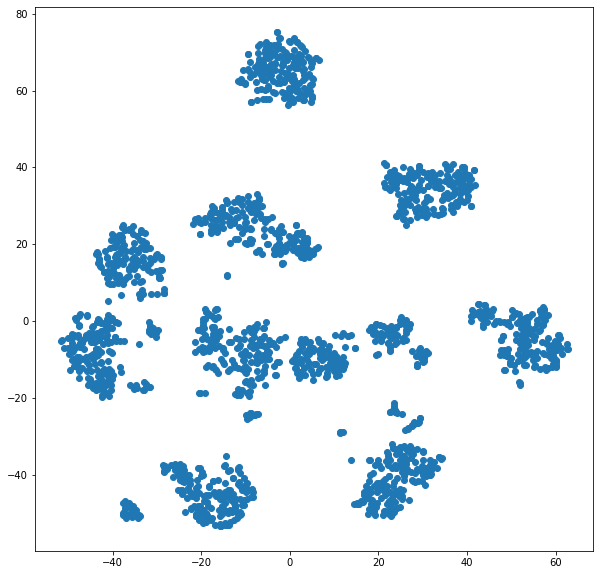

In [2]:
digits = datasets.load_digits()
data = digits.data
projection = TSNE().fit_transform(data)
plt.figure(figsize=(10,10))
plt.scatter(*projection.T)
data.shape

Now we import hdbscan and then cluster in the full 64 dimensional space. It is important to note that, if we wish to use the soft clustering we should use the prediction_data=True option for HDBSCAN. This will ensure we generate the extra data required that will allow soft clustering to work.

In [3]:
import hdbscan

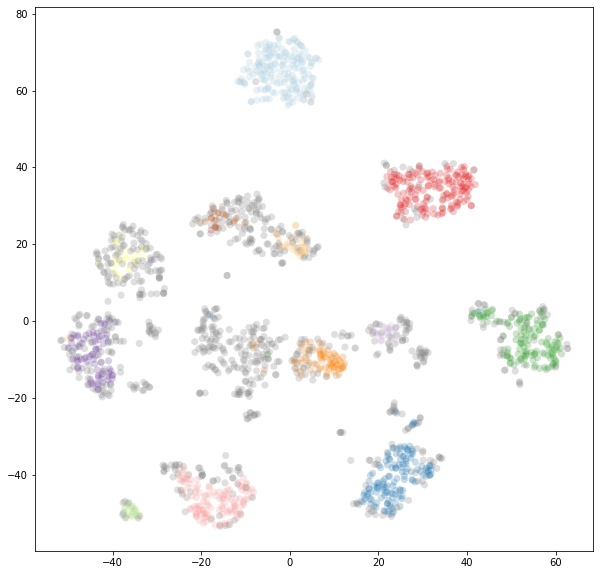

In [4]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(data)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.figure(figsize=(10,10))
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

Certainly a number of clusters were found, but the data is fairly noisy in 64 dimensions, so there are a number of points that have been classified as noise. We can generate a soft clustering to get more information about some of these noise points.

To generate a soft clustering for all the points in the original dataset we use the :py:func:`~hdbscan.prediction.all_points_membership_vectors` function which takes a clusterer object. If we wanted to get soft cluster membership values for a set of new unseen points we could use :py:func:`~hdbscan.prediction.membership_vector` instead.

The return value is a two-dimensional numpy array. Each point of the input data is assigned a vector of probabilities of being in a cluster. For a first pass we can visualize the data looking at what the most likely cluster was, by coloring according to the argmax of the probability vector (i.e. the cluster for which a given point has the highest probability of being in).

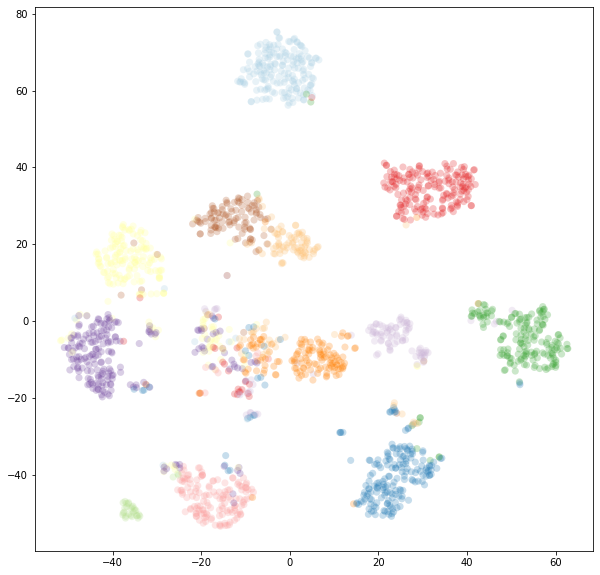

In [5]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.figure(figsize=(10,10))
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

This fills out the clusters nicely -- we see that there were many noise points that are most likely to belong to the clusters we would expect; we can also see where things have gotten confused in the middle, and there is a mix of cluster assignments.

We are still only using part of the information however; we can desaturate according to the actual probability value for the most likely cluster.

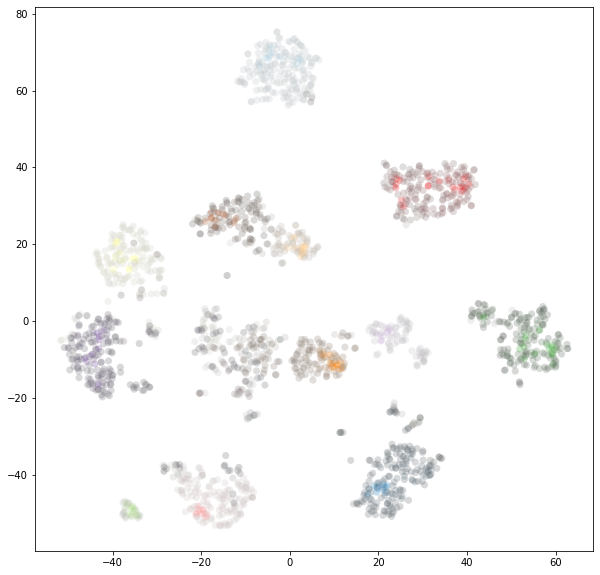

In [7]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [sns.desaturate(color_palette[np.argmax(x)], np.max(x))
                  for x in soft_clusters]
plt.figure(figsize=(10,10))
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

We see that many points actually have a low probability of being in the cluster -- indeed the soft clustering applies within a cluster, so only the very cores of each cluster have high probabilities. In practice desaturating is a fairly string treatment; visually a lot will look gray. We could apply a function and put a lower limit on the desaturation that meets better with human visual perception, but that is left as an exercise for the reader.

Instead we'll explore what else we can learn about the data from these cluster membership probabilities. An interesting question is which points have high likelihoods for two clusters (and low likelihoods for the other clusters).